# DataStream Class

The `DataStream` class is a holder and merger of data timeseries and metadata. It is the building block of the `DataLake` class which is what you will mainly be interested in. This walkthrough will show you how to use the `DataStream` class to load data from a file and calculate time averages.


```python
class DataStream():
    
    """A class for calculating time averages of data streams on-the-fly.

    Parameters:
    ----------
        header_list (list of str): A list of column headers for the data.
        average_times (list of float): A list of time intervals (in seconds)
            over which to calculate the data averages.
        average_base (float, optional): The base for the exponential moving
            average window used to smooth the data. Defaults to 2.0.

    Example:
    ----------
        # Create a DataStream object with two headers and two average intervals
        stream = DataStream(['time', 'value'], [10.0, 60.0])

        # Add data to the stream and calculate the rolling averages
        for data_point in my_data_stream:
            stream.add_data_point(data_point)
            rolling_averages = stream.calculate_averages()

    Attributes:
    ----------
        header_list (list of str): (n,) A list of column headers for the data.
        header_dict (dict): A dictionary mapping column headers to column
            indices.
        average_int_sec (list of float): A list of time intervals (in seconds)
            over which to calculate the data averages.
        data_stream (np.ndarray): (n, m) An array of data points.
            Rows match header indexes and columns match time.
        time_stream (np.ndarray): (m,) An array of timestamps corresponding
            to the data points.
        average_base_sec (float): The base for the exponential moving average
            window used to smooth the data.
        average_base_time (np.ndarray): An array of timestamps corresponding to
            the beginning of each average interval.
        average_base_data (np.ndarray): An array of average data values for
            each average interval.
        average_base_data_std (np.ndarray): An array of standard deviations of
            the data values for each average interval.
        average_epoch_start (int or None): The Unix epoch time (in seconds) of
            the start of the first average interval.
        average_epoch_end (int or None): The Unix epoch time (in seconds) of
            the end of the last average interval.
        average_dict (dict): A dictionary mapping average interval lengths to
            corresponding arrays of average data values.
    """
```

## Import the packages

In [1]:

import numpy as np
from matplotlib import pyplot as plt, dates
import os
from datetime import datetime

from datacula.lake.datastream import DataStream
from datacula import loader

# preferred settings for plotting
plt.rcParams.update({'text.color': "#333333",
                     'axes.labelcolor': "#333333",
                     "figure.figsize": (6,4),
                     "font.size": 14,
                     "axes.edgecolor": "#333333",
                     "axes.labelcolor": "#333333",
                     "xtick.color": "#333333",
                     "ytick.color": "#333333",
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})

## Settings dictionary

This dictionary, `settings_cpc`, contains configuration settings for a specific instrument called "CPC_3010". The settings are used for data processing, loading, and organization. Let's go through each key-value pair in the dictionary:

- "instrument_name": "CPC_3010": The name of the instrument, which is "CPC_3010" in this case.
- "data_stream_name": "CPC_3010": The name of the data stream associated with the instrument, also "CPC_3010" here.
- "data_loading_function": "general_load": The name of the function that will be used to load the data. In this case, it's a general loading function called "general_load".
- "relative_data_folder": "CPC_3010_data": The name of the folder where the data files for this instrument are stored, relative to the main data directory.
- "skipRowsDict": 0: The number of rows to skip at the beginning of the file while reading the data. In this case, no rows are skipped.
- "Time_shift_to_Linux_Epoch_sec": 0: The time shift (in seconds) to convert the timestamps in the data to Unix/Linux epoch time. No time shift is applied here.
- "data_checks": This dictionary contains data validation settings:
- "characters": [20,35]: The range of valid line lengths (in characters) for each row in the data file.
- "char_counts": {",": 4, "/": 0, ":": 0}: The expected number of occurrences of specific characters in each row of the data file. In this case, 4 commas are expected, while no forward slashes or colons should be present. This is general, more character-specific checks can be added to the dictionary.
- "skip_rows": 1: The number of rows to skip at the beginning of the file for data validation.
- "skip_end": 0: The number of rows to skip at the end of the file for data validation.
- "data_header": ["CPC_count[#/sec]", "Temp_[C]"]: The list of data column headers in the file.
- "data_column": [1, 2]: The indices of the data columns in the file.
- "time_column": 0: The index of the time column in the file.
- "time_format": "epoch": The format of the time values in the file. In this case, it's Unix/Linux epoch time.
- "filename_regex": "CPC_3010*.csv": The regular expression pattern to match the data file names for this instrument.
- "base_interval_sec": 2: The base time interval (in seconds) for the data.
- "data_delimiter": ",": The delimiter used to separate the data values in the file, which is a comma in this case.

The `settings_cpc` dictionary is a useful way to store all the necessary settings and configurations for a particular instrument or data stream. These settings can be used by various functions and methods to process and analyze the data accordingly.

In [2]:
settings_cpc = {
        "instrument_name": "CPC_3010",
        "data_stream_name": "CPC_3010",
        "data_loading_function": "general_load",
        "relative_data_folder": "CPC_3010_data",
        "skipRowsDict": 0,
        "Time_shift_to_Linux_Epoch_sec": 0,
        "data_checks": {
            "characters": [20,35],
            "char_counts": {",": 4, "/": 0, ":": 0},
            "skip_rows": 1,
            "skip_end": 0
        },
        "data_header": ["CPC_count[#/sec]", "Temp_[C]"],
        "data_column": [1,2],
        "time_column": 0,
        "time_format": "epoch",
        "filename_regex": "CPC_3010*.csv",
        "base_interval_sec": 2,
        "data_delimiter": ","
    }

## Path

Set the working path where the data is stored. For now we'll use the provided example data in this current directory.

But the path could be any where on your computer. For example, if you have a folder called "data" in your home directory, you could set the path to: `path = "U:\\data\\processing\\Campgain2023_of_aswsome\\data\\"`

In [3]:
# set the parent directory of the data folder, for now this is the same as the current working directory
# but this can be a completely different path

path = os.getcwd()


## Load the data

With the working directory set, we can now load the data. For this we use the `loader` module and call loader.data_raw_loader() with the file path as argument.


In [4]:

data_file = os.path.join(path, 'data', settings_cpc['relative_data_folder'], 'CPC_3010_data_20220701_Jul.csv')

print(data_file)

# load the data
raw_data = loader.data_raw_loader(data_file)

# print the first 2 rows
print(raw_data[:2])

u:\Areas\code_repos\datacula\docs\examples\data\CPC_3010_data\CPC_3010_data_20220701_Jul.csv
Loading data from: CPC_3010_data_20220701_Jul.csv
['1656651600,17731,17.0,0,0.017', '1656651602,17870,16.9,0,0.017']


## Clean up the data

Now we can apply some data checks that we defined in the settings dictionary. For this we use `loader.data_format_checks` and then we can convert that list of strings to a numpy array.

To do that next step we call `loader.sample_data()` with inputs from the settings dictionary and the data list we just cleaned up.

In [5]:
# This is done by the general_data_formatter function for timeseries data
# 2d data is a separate function

data = loader.data_format_checks(raw_data, settings_cpc['data_checks'])

# Sample the data to get the epoch times and the data
epoch_time, data_array = loader.sample_data(
    data=data,
    time_column=settings_cpc['time_column'],
    time_format=settings_cpc['time_format'],
    data_columns=settings_cpc['data_column'],
    delimiter=settings_cpc['data_delimiter'],
    date_offset=None,
    seconds_shift=settings_cpc['Time_shift_to_Linux_Epoch_sec'],
)

print(f"epoch_time: {epoch_time.shape}")
print(epoch_time[:5])
print(f"data_array: {data_array.shape}")
print(data_array[:5])

epoch_time: (24617,)
[1.65665160e+09 1.65665160e+09 1.65665161e+09 1.65665161e+09
 1.65665161e+09]
data_array: (24617, 2)
[[1.7870e+04 1.6900e+01]
 [1.8387e+04 1.7000e+01]
 [1.8855e+04 1.6900e+01]
 [1.8942e+04 1.7000e+01]
 [1.8705e+04 1.7200e+01]]


\\dcstorage.lanl.gov\253393\Areas\code_repos\datacula\datacula\loader.py:150: UserWarning: More than 0.5 of the rows have been filtered out based on the characters limit [20, 35] or skip rows.
  warnings.warn(


## One Step Loading

We can also do all of the above steps in one step using the `loader.data_loader()` function. This function combines the two calls above into one. It takes the path to the data directory and the settings dictionary as arguments. It then loads the data, applies the data checks, and converts the data to a numpy array.

In [6]:
epoch_time, data = loader.general_data_formatter(
    data=raw_data,
    data_checks=settings_cpc['data_checks'],
    data_column=settings_cpc['data_column'],
    time_column=settings_cpc['time_column'],
    time_format=settings_cpc['time_format'],
    delimiter=settings_cpc['data_delimiter'],
    date_offset=None,
    seconds_shift=settings_cpc['Time_shift_to_Linux_Epoch_sec']
)

# Transpose the data
# data = data.T

## DataStream

Now we can create a DataStream object with the data we just loaded. We'll use the `DataStream` class from the `datastream` module. We'll use the `header_list` and `average_times` from the settings dictionary to initialize the DataStream object.

In [7]:
# Initialize the datastream object
cpc_datastream = DataStream(
                    header_list=settings_cpc['data_header'],
                    average_times=[600],
                    average_base=settings_cpc['base_interval_sec']
                )

## Fill the DataStream

Now we can fill the DataStream object with the data we just loaded. We'll use the `DataStream.add_data_point()` method to add each data point to the DataStream object.

Note the tranpose of the data, we are expecting rows to be the different measurements and columns to be the different time points. So we need to transpose the data before adding it to the DataStream object.

In [8]:
# first transpose the data
data = data.T

cpc_datastream.add_data(
            time_stream=epoch_time,
            data_stream=data,
        )

## What is in there

The datastream object has a lot of attributes and methods. We can see them all by using the `dir()` function.

In [9]:
# what do we have in the datastream?
dir(cpc_datastream)[27:]  # the first 27 are the default python methods

['add_data',
 'add_processed_data',
 'average_base_data',
 'average_base_data_std',
 'average_base_sec',
 'average_base_time',
 'average_data',
 'average_dict',
 'average_epoch_end',
 'average_epoch_start',
 'average_int_sec',
 'average_to_base_interval',
 'check_average_data',
 'data_stream',
 'header_dict',
 'header_list',
 'merge_different_headers',
 'reaverage',
 'return_data',
 'return_header_dict',
 'return_header_list',
 'return_std',
 'return_time',
 'time_stream']

## Plot the data

Now with the data in the DataStream object we can plot it. We can use the return_* methods to get the data we want.

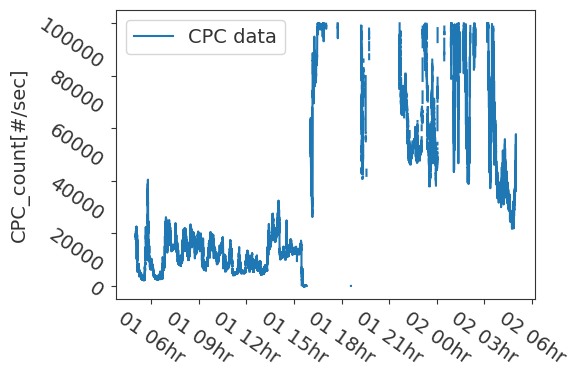

In [10]:
fig, ax = plt.subplots()
ax.plot(
    cpc_datastream.return_time(datetime64=True),
    cpc_datastream.return_data(keys=['CPC_count[#/sec]'])[0],
    label='CPC data'
)
plt.tick_params(rotation=-35)
ax.set_ylabel('CPC_count[#/sec]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %Hhr'))
ax.legend()
fig.tight_layout()

# For the raw data

If you want the raw unaveraged data add raw=True to the return_* methods. The default is raw=False, and you get the averaged data, which is on a uniform time grid.

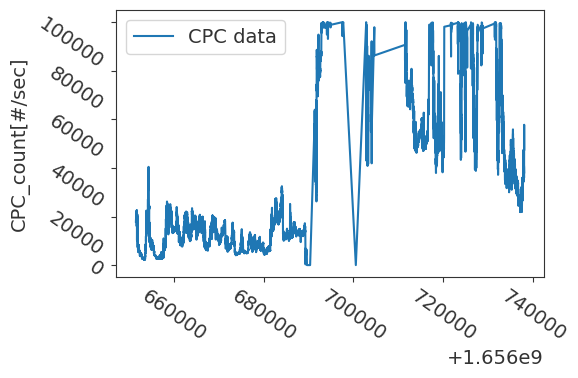

In [11]:
fig, ax = plt.subplots()
ax.plot(
    cpc_datastream.return_time(datetime64=False, raw=True),
    cpc_datastream.return_data(keys=['CPC_count[#/sec]'], raw=True)[0],
    label='CPC data'
)
plt.tick_params(rotation=-35)
ax.set_ylabel('CPC_count[#/sec]')
ax.legend()
fig.tight_layout()

## Reaverage the data

We can also reaverage the data. We can use the `DataStream.reaverage()` method to reaverage the data. This method takes the `reaverage_base_sec` from the settings dictionary as an argument, or you can specify a different base time interval.

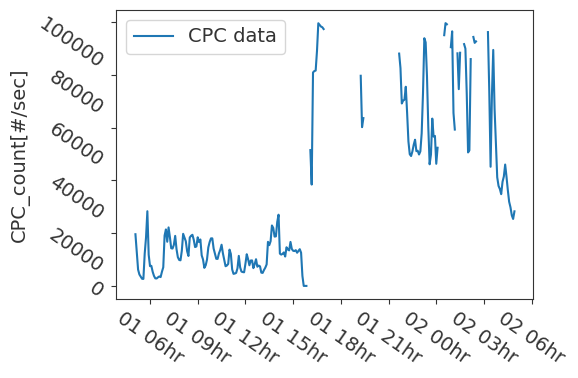

In [12]:
average_long = 300  # 5 min

cpc_datastream.reaverage(reaverage_base_sec=average_long)

fig, ax = plt.subplots()
ax.plot(
    cpc_datastream.return_time(datetime64=True),
    cpc_datastream.return_data(keys=['CPC_count[#/sec]'])[0],
    label='CPC data'
)
plt.tick_params(rotation=-35)
ax.set_ylabel('CPC_count[#/sec]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %Hhr'))
ax.legend()
fig.tight_layout()

## Time Ranges

You can also specify the time range to average over. This is useful if you want to average over a specific time range. For example, if you want to average over the first 10 minutes of data, you can specify the start and end times as arguments to the `DataStream.reaverage()` method.

Note there is some timezone vs UTC (epoch) you may need to shift around. Automating this is on the to-do list.

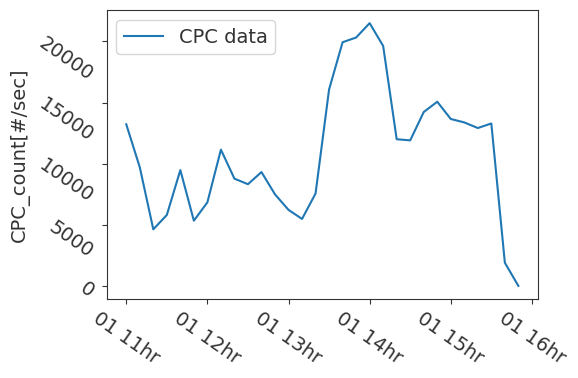

In [24]:
start = datetime.fromisoformat('2022-07-01T11:00:00').timestamp()-6*3600 # UTC shift
end = datetime.fromisoformat('2022-07-01T16:00:00').timestamp()-6*3600 # UTC shift

average_long = 600  # 5 min

cpc_datastream.reaverage(
    reaverage_base_sec=average_long,
    epoch_start=start,
    epoch_end=end
)

fig, ax = plt.subplots()
ax.plot(
    cpc_datastream.return_time(datetime64=True),
    cpc_datastream.return_data(keys=['CPC_count[#/sec]'])[0],
    label='CPC data'
)
plt.tick_params(rotation=-35)
ax.set_ylabel('CPC_count[#/sec]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %Hhr'))
ax.legend()
fig.tight_layout()

## Reaverage and Raw Data

The raw data is always stored in the DataStream object. So if you want to reaverage the raw data, you can use the `DataStream.reaverage()` method to set a new interval, and set epoch_start and epoch_end to None to average over the entire data range.

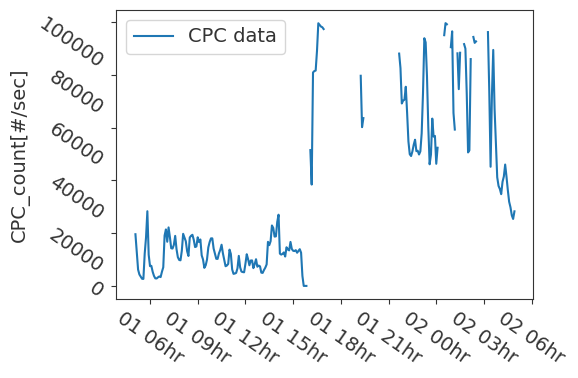

In [14]:
average_long = 300  # 5 min

cpc_datastream.reaverage(
    reaverage_base_sec=average_long,
    epoch_start=None,
    epoch_end=None
)

fig, ax = plt.subplots()
ax.plot(
    cpc_datastream.return_time(datetime64=True),
    cpc_datastream.return_data(keys=['CPC_count[#/sec]'])[0],
    label='CPC data'
)
plt.tick_params(rotation=-35)
ax.set_ylabel('CPC_count[#/sec]')
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %Hhr'))
ax.legend()
fig.tight_layout()